In [202]:
!pip install -U fsds_100719
import IPython.display as disp
disp.clear_output()
print('testing')

testing


In [2]:
# Shortcut import of 
# import pandas as pd, numpy as np, etc...
import fsds_100719 as fs
from fsds_100719.imports import *

Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


**Taking a preview of the data**

In [3]:
# Ignore pink warnings 
import warnings
warnings.filterwarnings('ignore')

# Allow for a large # of columns
pd.set_option('display.max_columns',0)
# pd.set_option('display.max_rows','')

df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


*Here, we see several variables, which upon initial inspection, I see as four main types:* 
1. Items we can directly control via renovations or timing we put home on market:
    ['bedrooms', 'date', 'bathrooms', 'sqft_living', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated']
2. Items we cannot control, but can help us in deciding the right homes/areas to look for our flip:
    ['sqft_lot', 'waterfront', 'view', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
3. Item we are using as our target:
    'price'
4. Variables we can drop:
    'id' --> due to us just wanting to see patterns, and it does not matter how we reference the sold home
    'view' --> we are just flipping. Marketing/understanding the complicated selling process will be left to the realtors


In [205]:
df.drop(columns=['id', 'view'], inplace=True)                                         #dropping id, view columns
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# SCRUB

In [206]:
for col in df.columns:
    print('----'*5)
    print(df[col].name)
    na = df[col].isna().sum()
    if na > 0:
        print(f'Number of NaNs: {na}\n')
    print(f'Most common values are:\n{df[col].value_counts()}')
    #find which ones have NaN values & weird values

--------------------
date
Most common values are:
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
1/10/2015      1
5/27/2015      1
7/27/2014      1
8/3/2014       1
8/30/2014      1
Name: date, Length: 372, dtype: int64
--------------------
price
Most common values are:
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64
--------------------
bedrooms
Most common values are:
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
--------------------
bathrooms
Most common values are:
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75  

*Waterfront* is missing over 10% of values. With it being whether a house has a view of the water, it's not exactly a simple variable to check up. One would literally have to see the view from the house. And since only 146 out of over 21K homes actually have a view, seems like a pointless column. Will drop

In [207]:
df.drop(columns='waterfront', inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


*sqft_basement* weirdly has '?' has value. Seeing as how we have a sqft_living for all the area of the house, and sqft_above, which measures everything outside of basement, makes sense to just set basement = total - above

In [208]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df.sqft_basement.value_counts()

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

*fix yr_renovated* has NaN's as well as 0's. If there is a NaN/0, I would assume no renovations were done, or at least none done legally with permits. In either situation, you can't promise a home has been renovated. So in those cases, the new value in this column is the yr the home was built. With that, the name of column is last_constructed to better reflect what it represents now

In [209]:
df['yr_renovated'].fillna(value=df.yr_built, inplace=True)  
df.loc[df['yr_renovated'] == 0, 'yr_renovated'] = df['yr_built']
df.rename(columns = {'yr_renovated': 'last_constructed'}, inplace=True)
df.last_constructed = df.last_constructed.astype('int64')     #it's a yr, shouldn't be a float
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0,1933,1933,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910,1965,1965,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0,1987,1987,98074,47.6168,-122.045,1800,7503


In [210]:
df.date = pd.to_datetime(df.date).dt.month
df.rename(columns = {'date': 'month_sold'}, inplace=True)

was having trouble w/ getting scatter plots of elements since date is not "graphable" in its form. Decided to change it to datetime object, so I can easily get the month. Really unlikely to get a home sold on the same day, so as it was, date was a horrible feature. One could possibly sell a home in a month that seems like prime-time to sell. Depending on models, may turn this into seasons of yr instead of months.

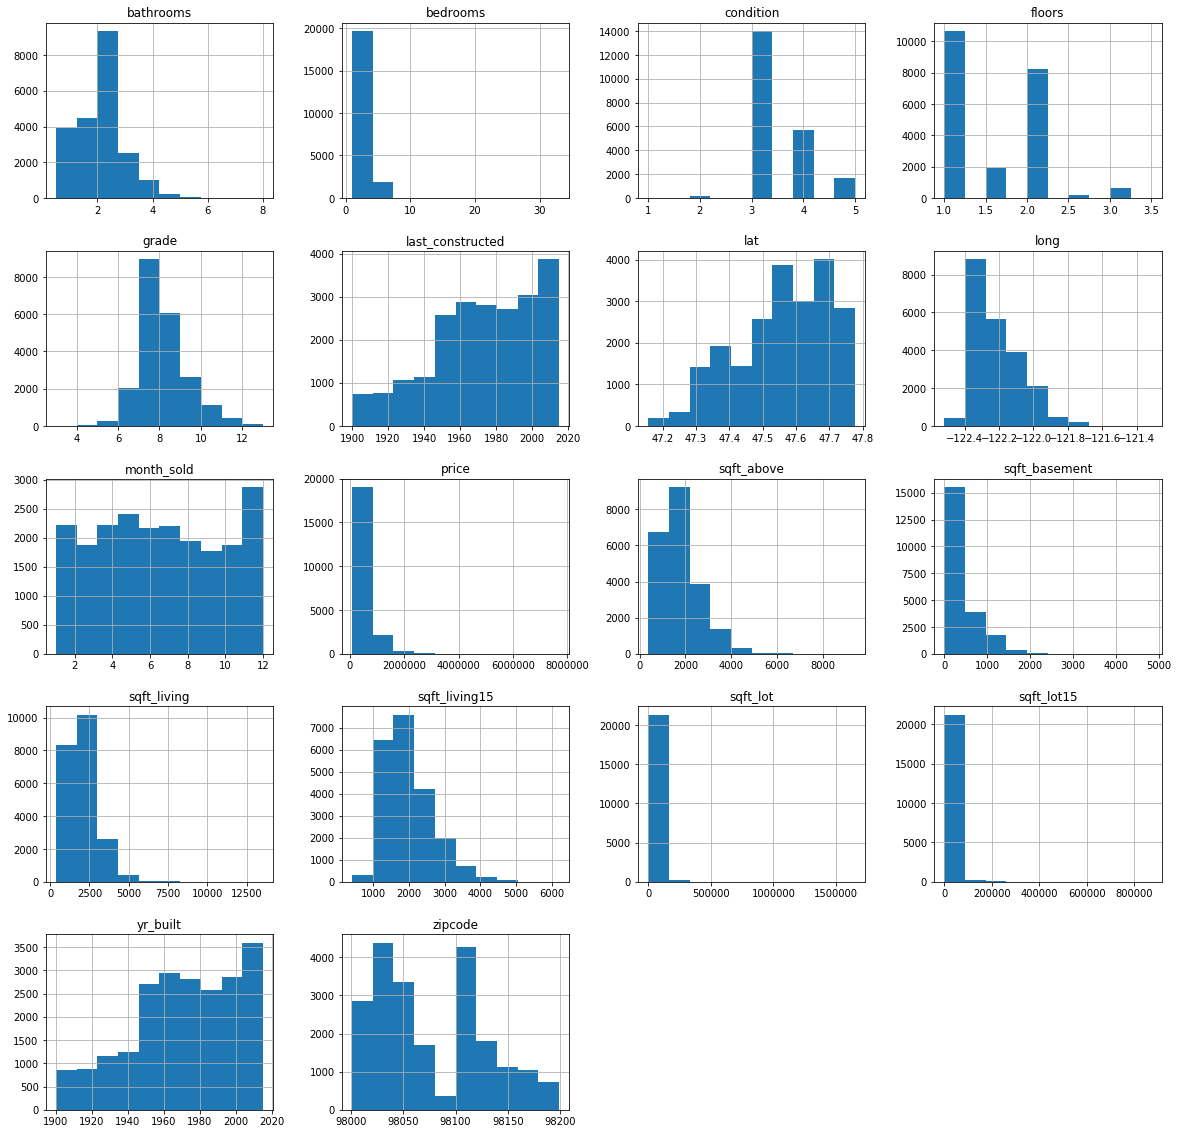

In [211]:
df.hist(figsize=(20,20));

*Due to the above scatterplots, can infer the following are categorical: 
    ['month_sold', 'floors', 'condition', 'grade', 'zipcode']
 Will deal with them after getting hist plots.*

*Certain outlier(s) having HUGE affects on my skews for 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_lot15'. Would appear to be an exceptionally huge home(s). Time to investigate!*

In [212]:
df.describe()

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,6.573969,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,291.725008,1970.999676,1972.945131,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.115061,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,442.667800,29.375234,28.945393,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000000,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,4.000000,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1954.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,6.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1977.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,9.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,1999.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,12.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [213]:
df[df['bedrooms']>=10]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
8748,8,520000.0,11,3.00,3000,4960,2.0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
13301,8,1150000.0,10,5.25,4590,10920,1.0,3,9,2500,2090,2008,2008,98004,47.5861,-122.113,2730,10400
15147,10,650000.0,10,2.00,3610,11914,2.0,4,7,3010,600,1958,1958,98006,47.5705,-122.175,2040,11914
15856,6,640000.0,33,1.75,1620,6000,1.0,5,7,1040,580,1947,1947,98103,47.6878,-122.331,1330,4700
19239,12,660000.0,10,3.00,2920,3745,2.0,4,7,1860,1060,1913,1913,98105,47.6635,-122.320,1810,3745


*We have just 5 homes with 10+ bedrooms. Will drop them not only due to skewness, but also I do not want to renovate that many homes*

In [214]:
df.drop(df[df['bedrooms']>=10].index, inplace=True)
df[df['bedrooms']>=10]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15


In [215]:
df[df['sqft_lot']>21780]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
5,5,1230000.0,4,4.50,5420,101930,1.0,3,11,3890,1530,2001,2001,98053,47.6561,-122.005,4760,101930
21,8,2000000.0,3,2.75,3050,44867,1.0,3,9,2330,720,1968,1968,98040,47.5316,-122.233,4110,20336
36,5,550000.0,4,1.00,1660,34848,1.0,1,5,930,730,1933,1933,98052,47.6621,-122.132,2160,11467
41,8,775000.0,4,2.25,4220,24186,1.0,3,8,2600,1620,1984,1984,98166,47.4450,-122.347,2410,30617
49,3,1350000.0,3,2.50,2753,65005,1.0,5,9,2165,588,1953,1953,98070,47.4041,-122.451,2680,72513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21478,7,915000.0,3,4.50,3850,62726,2.0,3,10,3120,730,2013,2013,98053,47.6735,-122.058,2630,46609
21490,5,2240000.0,5,6.50,7270,130017,2.0,3,12,6420,850,2010,2010,98027,47.5371,-121.982,1800,44890
21504,8,1410000.0,4,4.00,4920,50621,2.0,3,10,4280,640,2012,2012,98053,47.6575,-122.006,4920,74052
21509,11,1450000.0,4,3.50,4300,108865,2.0,3,11,4300,0,2014,2014,98074,47.6258,-122.005,4650,107498


*These are homes with lots bigger than half acre(21780 sqft). Since I would have to pay for landscaping, and I am not too familiar with doing so, will drop these huge lot-homes. Also, this homes are skewing my data, which can affect my model*

In [216]:
df.drop(df[df['sqft_lot']>=21780].index, inplace=True)
df[df['sqft_lot']>=21780]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15


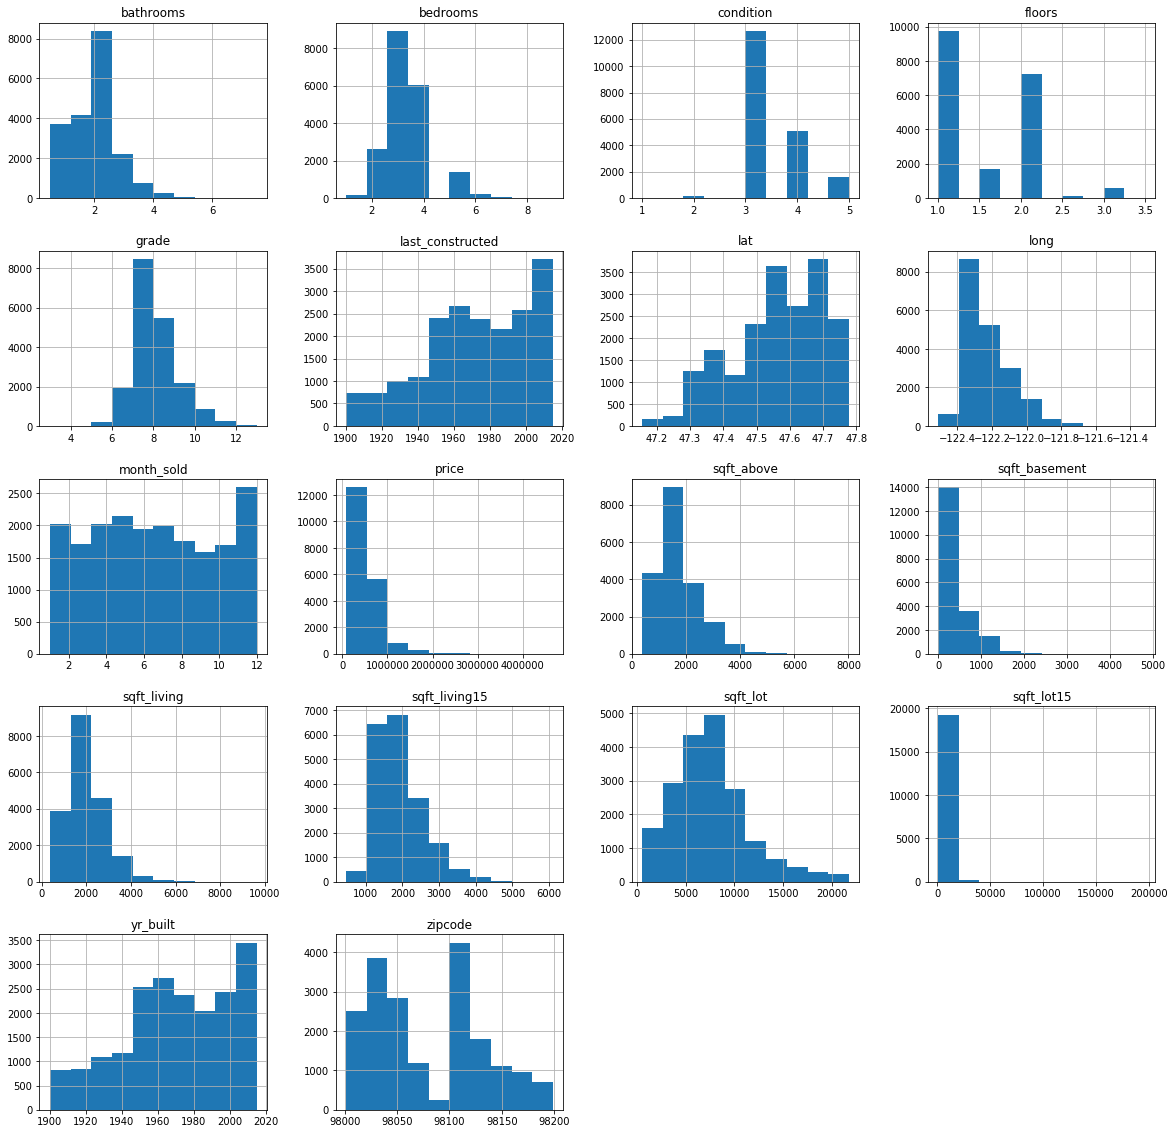

In [217]:
df.hist(figsize=(20,20));

In [218]:
df.corrwith(df['sqft_lot'])

month_sold         -0.005005
price               0.156105
bedrooms            0.214265
bathrooms           0.057374
sqft_living         0.284117
sqft_lot            1.000000
floors             -0.290519
condition           0.109256
grade               0.154121
sqft_above          0.238968
sqft_basement       0.137550
yr_built           -0.021215
last_constructed   -0.029397
zipcode            -0.259312
lat                -0.120555
long                0.240146
sqft_living15       0.322696
sqft_lot15          0.713697
dtype: float64

*Figured sqft_lot15 would be strongly correlated with sqft_lot, which it does have a .72 corr value. Will drop those homes as well since in real estate, you do not want your home to be vastly different from others. If someone is looking in a neighborhood with giant lots, they may be disappointed with the smaller lot I am working with.*

In [219]:
df.drop(df[df['sqft_lot15']>=21780].index, inplace=True)

*will do the same with homes over 1000 sqft larger than the avg American home size of 2700sqft., and homes over $1 million as I would be a beginner flipper and would not work with homes so costly*

In [220]:
df.drop(df[df['sqft_living']>3700].index, inplace=True)
df.drop(df[df['sqft_living15']>3700].index, inplace=True)
df.drop(df[df['price']>1_000_000].index, inplace=True)

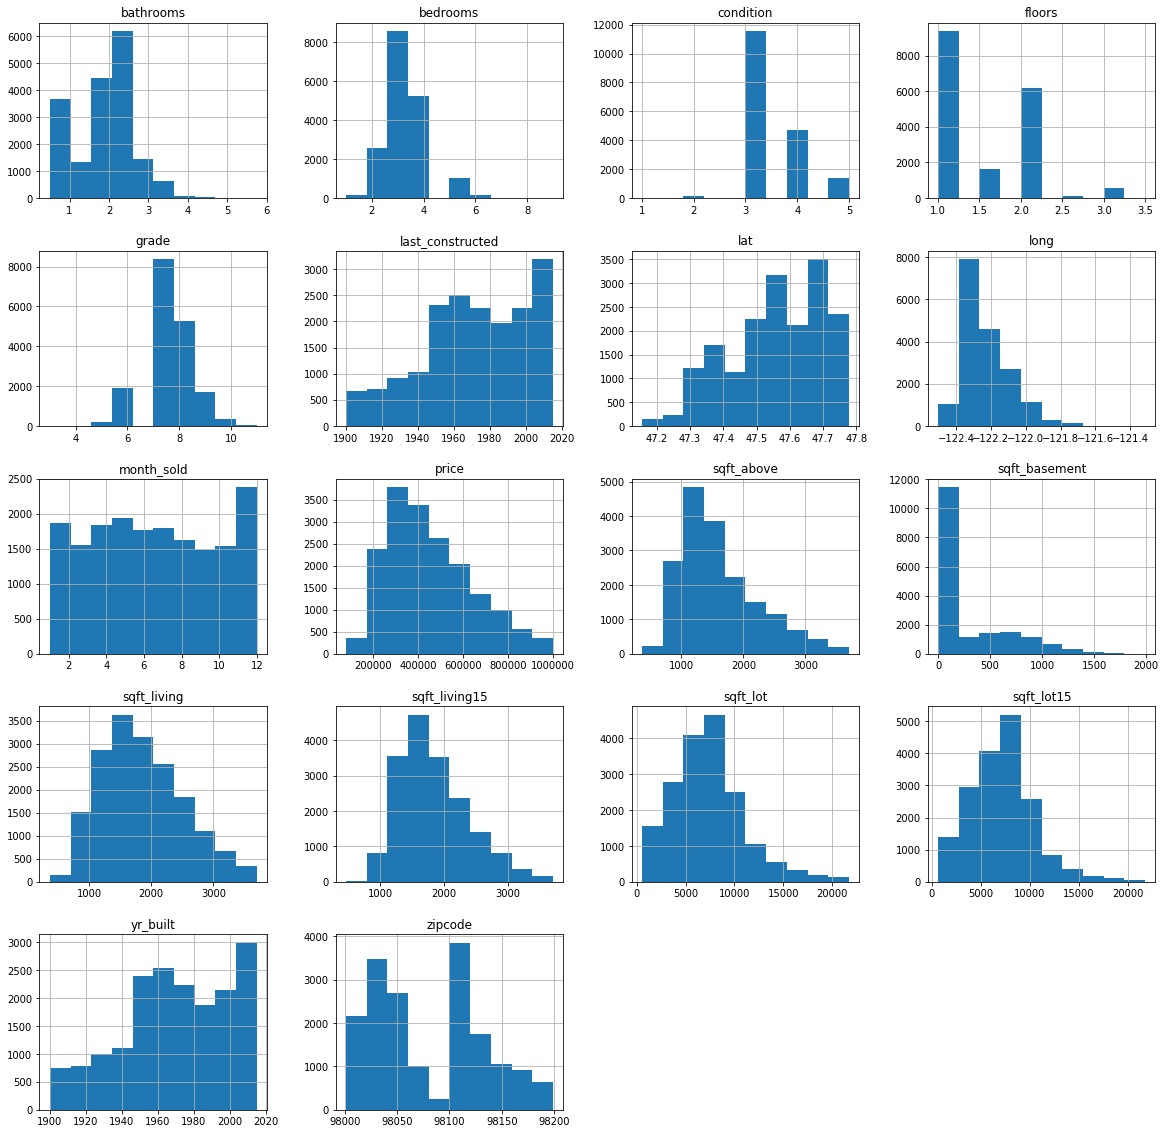

In [222]:
df.hist(figsize=(20,20));

In [223]:
price_corr = df.corrwith(df['price'])
price_corr.abs().sort_values(ascending=False)

price               1.000000
grade               0.572922
sqft_living         0.556873
sqft_living15       0.498249
lat                 0.469595
sqft_above          0.442360
bathrooms           0.386774
bedrooms            0.266237
floors              0.241970
sqft_basement       0.230926
condition           0.060042
sqft_lot15          0.042443
last_constructed    0.033949
sqft_lot            0.031685
long                0.016822
month_sold          0.013833
zipcode             0.008057
yr_built            0.002109
dtype: float64

*price is most correlated to ['grade', 'sqft_living','sqft_living15', 'lat', 'sqft_above', 'bathrooms']*

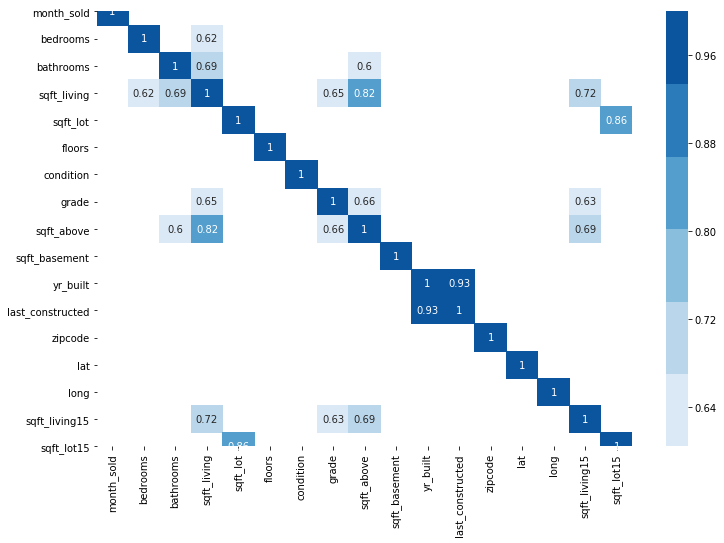

In [227]:
features = df.drop(columns='price')
corr = features.corr().abs()
plt.figure(figsize=(12,8))
sns.heatmap(data=corr[corr>.6], annot=True, cmap=sns.color_palette('Blues'));

*sqft_living has most colinearity. But is also a top item correlated to price. To fix this, I will drop sqft_above, and sq_ft below. Total living space is more of a measure people pay attention to then splitting. Sqft_lot is strongly correlated to sqft_lot15, so I will drop sqft_lot15 since sqft_lot is something most people can easily understand. Plus with the high correlation, this means lot sizes are similar to those of their neighbors already. Also dropping last_constructed as it has strong correlation to yr_built*

In [228]:
features.drop(columns=['sqft_above','sqft_basement', 'sqft_lot15', 'last_constructed'], inplace=True)
df.drop(columns=['sqft_above','sqft_basement', 'sqft_lot15', 'last_constructed'], inplace=True)

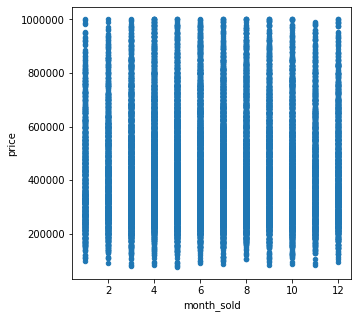

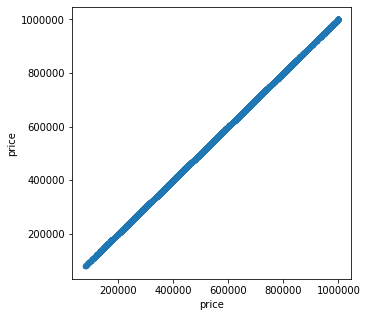

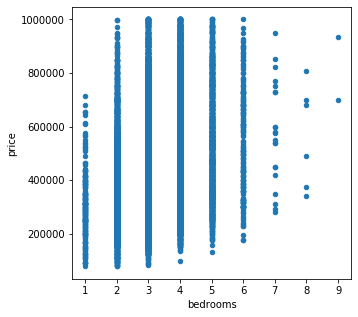

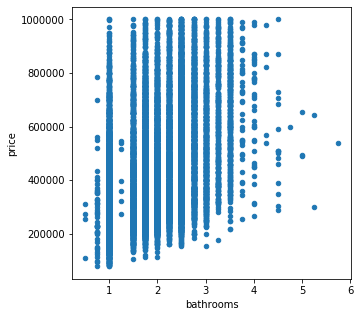

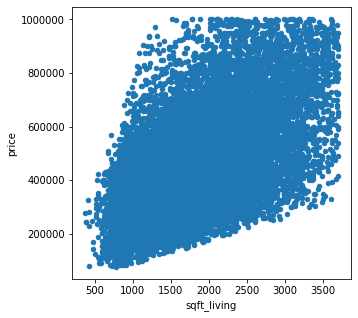

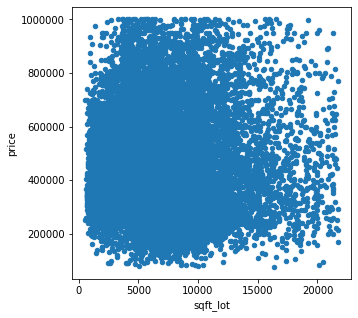

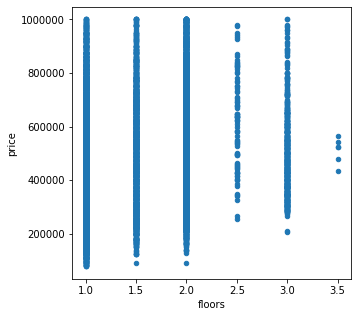

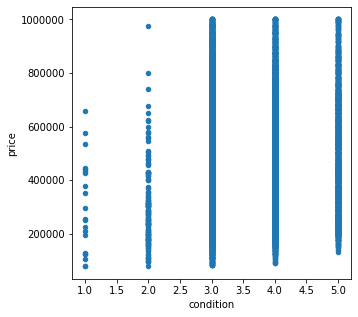

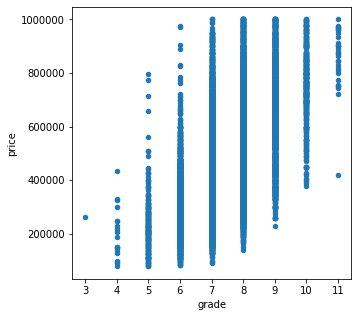

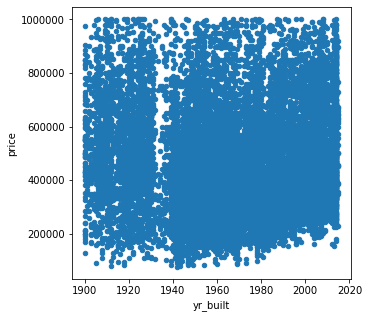

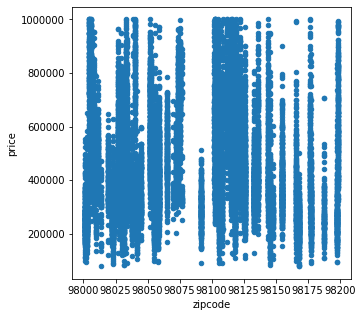

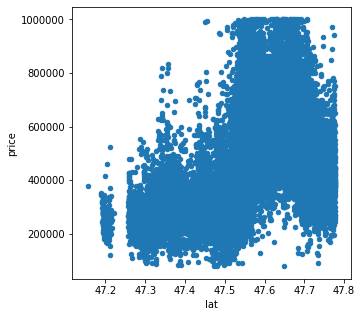

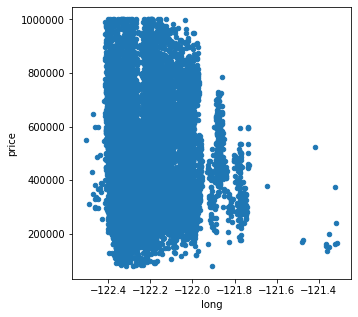

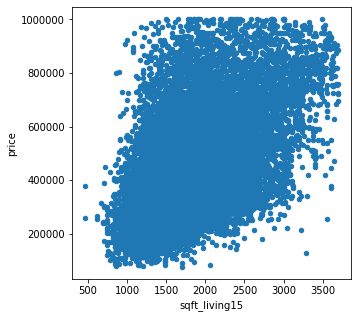

In [229]:
for col in df.columns:
    df.plot(kind='scatter',x=col,y='price', figsize=(5,5));
    plt.show()

*Due to the above scatterplots,and the definitions of the categories, I can deduce ['month_sold', 'condition', 'grade', and 'zipcode'] are all categorical

In [230]:
df.month_sold = df.month_sold.astype('category')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.zipcode = df.zipcode.astype('category')
df_beforescaler = df

In [231]:
features = df.drop(columns='price') #rewriting this as I changed df categoricals
features.head()

,month_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,lat,long,sqft_living15
0,10,3,1.00,1180,5650,1.0,3,7,1955,98178,47.5112,-122.257,1340
1,12,3,2.25,2570,7242,2.0,3,7,1951,98125,47.7210,-122.319,1690
2,2,2,1.00,770,10000,1.0,3,6,1933,98028,47.7379,-122.233,2720
3,12,4,3.00,1960,5000,1.0,5,7,1965,98136,47.5208,-122.393,1360
4,2,3,2.00,1680,8080,1.0,3,8,1987,98074,47.6168,-122.045,1800


In [232]:
features_cont = features.drop(columns=['month_sold', 'condition', 'grade', 'zipcode'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features_cont = scaler.fit_transform(features_cont)

In [234]:
for i in range(0,9):
    features_cont.iloc[:,i] = scaled_features_cont[:,i]

*Above I am scaling my continuous functions*

In [235]:
features_final = pd.concat([features_cont, features[['month_sold', 'condition', 'grade', 'zipcode']]], axis=1)

In [236]:
df = pd.concat([df['price'],features_final], axis=1)
df #combining the scaled features to the dataframe again

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,lat,long,sqft_living15,month_sold,condition,grade,zipcode
0,221900.0,-0.331598,-1.471215,-1.032020,-0.446302,-0.854640,-0.493261,-0.344310,-0.213452,-0.913782,10,3,7,98178
1,538000.0,-0.331598,0.377243,1.079917,-0.015396,0.992494,-0.627732,1.162913,-0.680136,-0.266098,12,3,7,98125
2,180000.0,-1.488266,-1.471215,-1.654965,0.731111,-0.854640,-1.232850,1.284324,-0.032800,1.639946,2,3,6,98028
3,604000.0,0.825069,1.486318,0.153096,-0.622237,-0.854640,-0.157085,-0.275343,-1.237146,-0.876772,12,5,7,98136
4,510000.0,-0.331598,0.007551,-0.272330,0.211426,-0.854640,0.582504,0.414330,1.382308,-0.062540,2,3,8,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,-0.331598,0.746934,-0.500237,-1.669458,2.839627,1.322092,1.007018,-0.883369,-0.562182,5,3,8,98103
21593,400000.0,0.825069,0.746934,0.684878,-0.402182,0.992494,1.490180,-0.347902,-1.003804,-0.007024,2,3,8,98146
21594,402101.0,-1.488266,-1.840907,-1.275120,-1.610181,0.992494,1.322092,0.253406,-0.529593,-1.505951,6,3,7,98144
21595,400000.0,-0.331598,0.746934,-0.393881,-1.329226,0.992494,1.154004,-0.176921,1.201656,-0.784246,1,3,8,98027


**time for a little RFE**

In [237]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
target = df.price
linreg = LinearRegression()
# linreg.fit(features_final, target.values.ravel())

In [242]:
selector = RFE(linreg, n_features_to_select=1)
selector = selector.fit(features_final, target.values.ravel())

In [243]:
selector.ranking_

array([10,  8,  1,  7,  9,  4,  2, 11,  5, 12,  6,  3, 13])

In [240]:
features_final.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'yr_built', 'lat', 'long', 'sqft_living15', 'month_sold', 'condition',
       'grade', 'zipcode'],
      dtype='object')

Most important are:
1. sqft_living
2. lat
3. grade
4. yr_built
5. sqft_living15
6. condition
7. sqft_lot
8. bathrooms
9. floors
10. bedrooms
11. long
12. month_sold
13. zipcode
*time to see how many of these variables to use*



In [241]:
R_squareds = []
for i in range(1,len(features_final.columns)+1):
    selector = RFE(linreg, n_features_to_select=i)
    selector.fit(features_final, target)
    linreg.fit(features_final[features_final.columns[selector.support_]], target)
    r_squared = linreg.score(features_final[features_final.columns[selector.support_]], target)
    R_squareds.append(r_squared)
R_squareds

[0.31010797541008495,
 0.5341509269891127,
 0.5864767575448824,
 0.6380059645500338,
 0.6455643863771612,
 0.6504133359376916,
 0.6633380797440263,
 0.6656927198221767,
 0.6671953604525196,
 0.6685152092769413,
 0.6686387891735817,
 0.6700587441439927,
 0.6722757142973791]

*This says the improvement moves up quickest from 1 to 2 features. But my categoricals still should be hot-coded let's see what we can find.*


**Model 1**

In [275]:
import statsmodels.formula.api as smf
#Below I included 2 continuous features plus the categoricals
f = 'price~month_sold+condition+grade+zipcode+sqft_living+lat'
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     832.2
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:52:50   Log-Likelihood:            -2.2679e+05
No. Observations:               17821   AIC:                         4.538e+05
Df Residuals:                   17726   BIC:                         4.545e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.697e+05   8.46e+04      3.188      0.001    1.04e+05    4.35e+05
month_sold[T.2]   6332.4209   3819.342      1.658      0.097   -1153.863    1.38e+04
month_sold[T.3]       2e+04   3543.254      5.645      0.000    1.31e+04    2.69e+04
month_sold[T.4]   3.178e+04   3451.146      9.208      0.000     2.5e+04    3.85e+04
month_sold[T.5]   4049.3274   3426.006      1.182      0.237   -2665.980    1.08e+04
month_sold[T.6]   1722.4669   3477.089      0.495      0.620   -5092.967    8537.901
month_sold[T.7]  -1427.2172   3464.518     -0.412      0.680   -8218.012    5363.577
month_sold[T.8]  -2461.7636   3523.249     -0.699      0.485   -9367.677    4444.150
month_sold[T.9]  -4677.0850   3578.420     -1.307      0.191   -1.17e+04    2336.968
month_sold[T.10] -5957.6433   3550.396     -1.678      0.093   -1.29e+04    1001.479
month_sold[T.11] -6197.2585   3736.791     -1.658      0.097   -1.35e+04    1127.217
month_sold[T.12] -3834.6695   3712.713     -1.033      0.302   -1.11e+04    3442.612
condition[T.2]    4.421e+04   1.93e+04      2.292      0.022    6404.870     8.2e+04
condition[T.3]    7.068e+04    1.8e+04      3.922      0.000    3.54e+04    1.06e+05
condition[T.4]    9.651e+04    1.8e+04      5.351      0.000    6.12e+04    1.32e+05
condition[T.5]    1.282e+05   1.81e+04      7.072      0.000    9.26e+04    1.64e+05
grade[T.4]       -1.161e+05   8.41e+04     -1.381      0.167   -2.81e+05    4.87e+04
grade[T.5]         -1.3e+05   8.21e+04     -1.582      0.114   -2.91e+05     3.1e+04
grade[T.6]       -1.256e+05    8.2e+04     -1.532      0.125   -2.86e+05    3.51e+04
grade[T.7]       -1.029e+05    8.2e+04     -1.256      0.209   -2.64e+05    5.77e+04
grade[T.8]       -6.183e+04    8.2e+04     -0.754      0.451   -2.23e+05    9.88e+04
grade[T.9]        1.595e+04    8.2e+04      0.194      0.846   -1.45e+05    1.77e+05
grade[T.10]       5.198e+04   8.21e+04      0.633      0.527   -1.09e+05    2.13e+05
grade[T.11]       1.375e+05   8.34e+04      1.649      0.099    -2.6e+04    3.01e+05
zipcode[T.98002]  1599.8061   7477.217      0.214      0.831   -1.31e+04    1.63e+04
zipcode[T.98003]  7599.3347   6876.772      1.105      0.269   -5879.812    2.11e+04
zipcode[T.98004]  5.115e+05   1.46e+04     35.152      0.000    4.83e+05     5.4e+05
zipcode[T.98005]  3.414e+05   1.45e+04     23.487      0.000    3.13e+05     3.7e+05
zipcode[T.98006]  2.799e+05   1.17e+04     23.934      0.000    2.57e+05    3.03e+05
zipcode[T.98007]  2.546e+05   1.45e+04     17.534      0.000    2.26e+05    2.83e+05
zipcode[T.98008]  2.546e+05   1.38e+04     18.461      0.000    2.28e+05    2.82e+05
zipcode[T.98010]      9e+04   1.22e+04      7.390      0.000    6.61e+04    1.14e+05
zipcode[T.98011]  1.591e+05    1.9e+04      8.353      0.000    1.22e+05    1.96e+05
zipcode[T.98014]  1.071

*Let's see what happens if I break up the data!*

In [251]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'yr_built', 'lat', 'long', 'sqft_living15', 'month_sold', 'condition',
       'grade', 'zipcode'],
      dtype='object')

In [253]:
df_reno = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'month_sold', 'condition', 'grade']]

In [254]:
df_cant_reno = df[['price', 'sqft_lot', 'yr_built', 'lat', 'long', 'sqft_living15', 'zipcode']]

*df_reno has items I can change/renovate plus price. df_cant_reno has the more permanent items I can't control for plus price*

**Model 2 (Items I can renovate)**

In [255]:
#using categoricals plus 2 most important of the features I can influence
f_reno = 'price~C(month_sold)+C(condition)+C(grade)+sqft_living+bathrooms'
model_reno = smf.ols(formula=f_reno, data=df_reno).fit()
model_reno.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     511.5
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:41:06   Log-Likelihood:            -2.3701e+05
No. Observations:               17821   AIC:                         4.741e+05
Df Residuals:                   17795   BIC:                         4.743e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.832e+05   1.48e+05      1.911      0.056   -7243.208    5.74e+05
C(month_sold)[T.2]   6335.8659   6753.321      0.938      0.348   -6901.301    1.96e+04
C(month_sold)[T.3]   2.781e+04   6265.342      4.439      0.000    1.55e+04    4.01e+04
C(month_sold)[T.4]   4.209e+04   6099.848      6.900      0.000    3.01e+04     5.4e+04
C(month_sold)[T.5]   2.198e+04   6054.137      3.631      0.000    1.01e+04    3.38e+04
C(month_sold)[T.6]   1.785e+04   6144.561      2.905      0.004    5804.141    2.99e+04
C(month_sold)[T.7]   1.216e+04   6122.712      1.986      0.047     157.467    2.42e+04
C(month_sold)[T.8]    1.27e+04   6228.152      2.040      0.041     494.808    2.49e+04
C(month_sold)[T.9]   1.266e+04   6326.427      2.001      0.045     261.903    2.51e+04
C(month_sold)[T.10]  1.019e+04   6275.077      1.623      0.105   -2114.172    2.25e+04
C(month_sold)[T.11]  6076.5938   6605.566      0.920      0.358   -6870.958     1.9e+04
C(month_sold)[T.12]  1475.4077   6565.507      0.225      0.822   -1.14e+04    1.43e+04
C(condition)[T.2]   -3.503e+04    3.4e+04     -1.029      0.304   -1.02e+05    3.17e+04
C(condition)[T.3]   -1.959e+04   3.18e+04     -0.616      0.538   -8.19e+04    4.27e+04
C(condition)[T.4]    1.693e+04   3.18e+04      0.532      0.595   -4.54e+04    7.93e+04
C(condition)[T.5]    7.877e+04    3.2e+04      2.464      0.014    1.61e+04    1.41e+05
C(grade)[T.4]        5883.1435   1.48e+05      0.040      0.968   -2.85e+05    2.97e+05
C(grade)[T.5]        5237.6077   1.45e+05      0.036      0.971   -2.79e+05    2.89e+05
C(grade)[T.6]        4.633e+04   1.45e+05      0.320      0.749   -2.37e+05     3.3e+05
C(grade)[T.7]        1.141e+05   1.45e+05      0.789      0.430   -1.69e+05    3.98e+05
C(grade)[T.8]        2.038e+05   1.45e+05      1.408      0.159   -7.99e+04    4.87e+05
C(grade)[T.9]        3.105e+05   1.45e+05      2.145      0.032    2.67e+04    5.94e+05
C(grade)[T.10]       3.737e+05   1.45e+05      2.578      0.010    8.95e+04    6.58e+05
C(grade)[T.11]       4.488e+05   1.47e+05      3.051      0.002     1.6e+05    7.37e+05
sqft_living          6.387e+04   1681.849     37.978      0.000    6.06e+04    6.72e+04
bathrooms           -1.284e+04   1591.862     -8.063      0.000    -1.6e+04   -9715.207
==============================================================================
Omnibus:                      687.952   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              771.034
Skew:                           0.493   Prob(JB):                    3.73e-168
Kurtosis:                       3.254   Cond. No.                         560.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance

*R2 went down :( Next try the ones I don't have control over*

**Model 3(features I can't renovate)**

In [261]:
f_cant_reno = 'price~zipcode+lat+yr_built'
model_cant = smf.ols(formula=f_cant_reno, data=df_cant_reno).fit()
model_cant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     296.9
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:45:27   Log-Likelihood:            -2.3486e+05
No. Observations:               17821   AIC:                         4.699e+05
Df Residuals:                   17749   BIC:                         4.704e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.791e+05    1.7e+04     16.452      0.000    2.46e+05    3.12e+05
zipcode[T.98002] -2.253e+04   1.17e+04     -1.922      0.055   -4.55e+04     444.700
zipcode[T.98003]  1.688e+04   1.08e+04      1.563      0.118   -4284.323     3.8e+04
zipcode[T.98004]  5.283e+05   2.29e+04     23.116      0.000    4.83e+05    5.73e+05
zipcode[T.98005]  4.152e+05   2.28e+04     18.216      0.000    3.71e+05     4.6e+05
zipcode[T.98006]  3.785e+05   1.83e+04     20.668      0.000    3.43e+05    4.14e+05
zipcode[T.98007]  2.955e+05   2.28e+04     12.966      0.000    2.51e+05     3.4e+05
zipcode[T.98008]  2.673e+05   2.17e+04     12.346      0.000    2.25e+05     3.1e+05
zipcode[T.98010]  6.406e+04   1.91e+04      3.355      0.001    2.66e+04    1.01e+05
zipcode[T.98011]  1.713e+05   2.99e+04      5.726      0.000    1.13e+05     2.3e+05
zipcode[T.98014]  1.654e+04   3.02e+04      0.548      0.584   -4.27e+04    7.57e+04
zipcode[T.98019]   9.75e+04   2.93e+04      3.330      0.001    4.01e+04    1.55e+05
zipcode[T.98022]  9471.0729   1.44e+04      0.656      0.512   -1.88e+04    3.78e+04
zipcode[T.98023]  9151.3736   9419.496      0.972      0.331   -9311.758    2.76e+04
zipcode[T.98024]  8.212e+04   3.12e+04      2.631      0.009    2.09e+04    1.43e+05
zipcode[T.98027]   2.61e+05   1.79e+04     14.574      0.000    2.26e+05    2.96e+05
zipcode[T.98028]  1.445e+05   2.94e+04      4.912      0.000    8.68e+04    2.02e+05
zipcode[T.98029]   2.72e+05   1.86e+04     14.611      0.000    2.35e+05    3.08e+05
zipcode[T.98030]  1.714e+04   1.16e+04      1.479      0.139   -5570.006    3.99e+04
zipcode[T.98031]  1.746e+04   1.23e+04      1.419      0.156   -6658.295    4.16e+04
zipcode[T.98032] -1.367e+04   1.44e+04     -0.948      0.343   -4.19e+04    1.46e+04
zipcode[T.98033]  3.311e+05    2.5e+04     13.242      0.000    2.82e+05     3.8e+05
zipcode[T.98034]  1.623e+05   2.69e+04      6.026      0.000     1.1e+05    2.15e+05
zipcode[T.98038]  5.163e+04   9903.611      5.213      0.000    3.22e+04     7.1e+04
zipcode[T.98039]  6.237e+05   5.64e+04     11.050      0.000    5.13e+05    7.34e+05
zipcode[T.98040]   5.29e+05   2.04e+04     25.871      0.000    4.89e+05    5.69e+05
zipcode[T.98042]  1.295e+04   1.01e+04      1.280      0.201   -6881.695    3.28e+04
zipcode[T.98045]  8.516e+04   1.64e+04      5.204      0.000    5.31e+04    1.17e+05
zipcode[T.98052]  3.087e+05   2.45e+04     12.610      0.000    2.61e+05    3.57e+05
zipcode[T.98053]  2.405e+05   2.63e+04      9.157      0.000    1.89e+05    2.92e+05
zipcode[T.98055]  2.988e+04   1.42e+04      2.104      0.035    2045.100    5.77e+04
zipcode[T.98056]  1.136e+05   1.57e+04      7.230      0.000    8.28e+04    1.44e+05
zipcode[T.98058]  5.453e+04   1.29e+04      4.219      0.000    2.92e+04    7.99e+04
zipcode[T.98059]  1.461

In [264]:
print(f'Model1 total High Pvalues: {sum(np.abs(model.pvalues) > .05)}\n')
print(f'Model_reno total High Pvalues: {sum(np.abs(model_reno.pvalues) > .05)}\n') 
print(f'Model_cant_reno total High Pvalues: {sum(np.abs(model_cant.pvalues) > .05)}\n')

Model1 total High Pvalues: 25

Model_reno total High Pvalues: 13

Model_cant_reno total High Pvalues: 13



R2 decreased with items I have control over, but increased for what I don't control(still less than overall model.
What I can't control also is tied with what I can control for the fewest high p-values.

**Model 4(Initial model but just zipcode as my only Categorical since Model3 R2 > Model2 R2)**

In [266]:
f = 'price~zipcode+sqft_living+lat'
model = smf.ols(formula=f, data=df).fit()
display(sum(np.abs(model.pvalues) > .05))
model.summary()

6

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     891.2
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:47:42   Log-Likelihood:            -2.2831e+05
No. Observations:               17821   AIC:                         4.568e+05
Df Residuals:                   17749   BIC:                         4.573e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          2.71e+05   1.17e+04     23.082      0.000    2.48e+05    2.94e+05
zipcode[T.98002]  1927.1536   8107.302      0.238      0.812    -1.4e+04    1.78e+04
zipcode[T.98003]  1.509e+04   7471.724      2.020      0.043     447.929    2.97e+04
zipcode[T.98004]  5.233e+05   1.58e+04     33.105      0.000    4.92e+05    5.54e+05
zipcode[T.98005]  3.637e+05   1.58e+04     23.050      0.000    3.33e+05    3.95e+05
zipcode[T.98006]  3.154e+05   1.27e+04     24.871      0.000    2.91e+05     3.4e+05
zipcode[T.98007]  2.738e+05   1.58e+04     17.357      0.000    2.43e+05    3.05e+05
zipcode[T.98008]  2.626e+05    1.5e+04     17.527      0.000    2.33e+05    2.92e+05
zipcode[T.98010]  9.147e+04   1.32e+04      6.921      0.000    6.56e+04    1.17e+05
zipcode[T.98011]   1.57e+05   2.07e+04      7.578      0.000    1.16e+05    1.98e+05
zipcode[T.98014]  9.238e+04   2.09e+04      4.417      0.000    5.14e+04    1.33e+05
zipcode[T.98019]  9.327e+04   2.03e+04      4.602      0.000    5.35e+04    1.33e+05
zipcode[T.98022]  2.426e+04   9992.219      2.428      0.015    4674.432    4.38e+04
zipcode[T.98023] -4197.8747   6520.565     -0.644      0.520    -1.7e+04    8583.070
zipcode[T.98024]  1.268e+05   2.16e+04      5.869      0.000    8.44e+04    1.69e+05
zipcode[T.98027]  2.454e+05   1.24e+04     19.801      0.000    2.21e+05     2.7e+05
zipcode[T.98028]  1.423e+05   2.04e+04      6.987      0.000    1.02e+05    1.82e+05
zipcode[T.98029]  2.589e+05   1.29e+04     20.102      0.000    2.34e+05    2.84e+05
zipcode[T.98030]  9018.4877   8020.640      1.124      0.261   -6702.750    2.47e+04
zipcode[T.98031]  1.721e+04   8517.784      2.021      0.043     515.297    3.39e+04
zipcode[T.98032]  3576.5373   9976.469      0.358      0.720    -1.6e+04    2.31e+04
zipcode[T.98033]  3.304e+05   1.73e+04     19.087      0.000    2.96e+05    3.64e+05
zipcode[T.98034]  1.867e+05   1.86e+04     10.013      0.000     1.5e+05    2.23e+05
zipcode[T.98038]  3.762e+04   6845.207      5.496      0.000    2.42e+04     5.1e+04
zipcode[T.98039]  6.806e+05   3.91e+04     17.418      0.000    6.04e+05    7.57e+05
zipcode[T.98040]  4.659e+05   1.41e+04     32.926      0.000    4.38e+05    4.94e+05
zipcode[T.98042]  1.585e+04   7001.697      2.264      0.024    2127.977    2.96e+04
zipcode[T.98045]  1.089e+05   1.13e+04      9.610      0.000    8.67e+04    1.31e+05
zipcode[T.98052]  2.771e+05   1.69e+04     16.350      0.000    2.44e+05     3.1e+05
zipcode[T.98053]  2.588e+05   1.82e+04     14.237      0.000    2.23e+05    2.94e+05
zipcode[T.98055]  4.336e+04   9826.700      4.412      0.000    2.41e+04    6.26e+04
zipcode[T.98056]   1.13e+05   1.09e+04     10.389      0.000    9.17e+04    1.34e+05
zipcode[T.98058]  4.583e+04   8946.404      5.123      0.000    2.83e+04    6.34e+04
zipcode[T.98059]  1.054

*using just zipcodes in my original model(that was the only categorical value for my cant_reno model which had the fewest pvalues.....pvalues drop to 6, and my R2 dropped only a little bit to .781

**Model 5(Using the renovate model(Model2) but with zipcode replacing all the categoricals)**

In [268]:
f_reno = 'price~zipcode+sqft_living+condition'
model_reno = smf.ols(formula=f_reno, data=df).fit()
display(sum(np.abs(model_reno.pvalues) > .05))
model_reno.summary()

7

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     874.1
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:48:30   Log-Likelihood:            -2.2815e+05
No. Observations:               17821   AIC:                         4.565e+05
Df Residuals:                   17746   BIC:                         4.570e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.671e+05   1.99e+04      8.381      0.000    1.28e+05    2.06e+05
zipcode[T.98002] -4838.3124   8053.232     -0.601      0.548   -2.06e+04    1.09e+04
zipcode[T.98003]  1.458e+04   7405.140      1.969      0.049      68.471    2.91e+04
zipcode[T.98004]  5.223e+05   9137.016     57.158      0.000    5.04e+05     5.4e+05
zipcode[T.98005]  3.597e+05   9672.880     37.190      0.000    3.41e+05    3.79e+05
zipcode[T.98006]  3.105e+05   6952.574     44.666      0.000    2.97e+05    3.24e+05
zipcode[T.98007]  2.723e+05   9216.122     29.545      0.000    2.54e+05     2.9e+05
zipcode[T.98008]  2.601e+05   7483.458     34.760      0.000    2.45e+05    2.75e+05
zipcode[T.98010]  8.554e+04   1.31e+04      6.533      0.000    5.99e+04    1.11e+05
zipcode[T.98011]  1.616e+05   8286.511     19.506      0.000    1.45e+05    1.78e+05
zipcode[T.98014]  9.775e+04   1.37e+04      7.155      0.000     7.1e+04    1.25e+05
zipcode[T.98019]  1.006e+05   8909.322     11.290      0.000    8.31e+04    1.18e+05
zipcode[T.98022]  1.608e+04   8809.044      1.825      0.068   -1189.545    3.33e+04
zipcode[T.98023] -4862.0403   6468.405     -0.752      0.452   -1.75e+04    7816.665
zipcode[T.98024]  1.291e+05   1.87e+04      6.920      0.000    9.25e+04    1.66e+05
zipcode[T.98027]  2.482e+05   7601.564     32.647      0.000    2.33e+05    2.63e+05
zipcode[T.98028]  1.467e+05   7439.184     19.715      0.000    1.32e+05    1.61e+05
zipcode[T.98029]  2.636e+05   7214.155     36.534      0.000    2.49e+05    2.78e+05
zipcode[T.98030]  1.009e+04   7553.009      1.336      0.181   -4712.113    2.49e+04
zipcode[T.98031]   1.53e+04   7462.882      2.050      0.040     670.490    2.99e+04
zipcode[T.98032]  -712.8730   9534.836     -0.075      0.940   -1.94e+04     1.8e+04
zipcode[T.98033]  3.298e+05   6983.130     47.223      0.000    3.16e+05    3.43e+05
zipcode[T.98034]  1.892e+05   6357.599     29.755      0.000    1.77e+05    2.02e+05
zipcode[T.98038]  4.003e+04   6408.153      6.247      0.000    2.75e+04    5.26e+04
zipcode[T.98039]  6.775e+05   3.63e+04     18.663      0.000    6.06e+05    7.49e+05
zipcode[T.98040]  4.604e+05   9144.525     50.346      0.000    4.42e+05    4.78e+05
zipcode[T.98042]  1.259e+04   6511.285      1.934      0.053    -169.308    2.54e+04
zipcode[T.98045]  1.122e+05   8900.911     12.603      0.000    9.47e+04     1.3e+05
zipcode[T.98052]  2.802e+05   6380.339     43.918      0.000    2.68e+05    2.93e+05
zipcode[T.98053]   2.66e+05   7802.660     34.095      0.000    2.51e+05    2.81e+05
zipcode[T.98055]  4.407e+04   7435.371      5.927      0.000    2.95e+04    5.86e+04
zipcode[T.98056]  1.071e+05   6771.751     15.815      0.000    9.38e+04     1.2e+05
zipcode[T.98058]  4.461e+04   6714.341      6.644      0.000    3.14e+04    5.78e+04
zipcode[T.98059]   1.05

*zipcode is valuable as it also dropped pvalues and brought R2 up for my can_reno model. While zipcode does have pvalues, it helps with R2 as shown with my original model below w/o zipcode*

**Model 6(Experimenting how my initial Model works w/o Zipcode to see the effect of it on accuracy)**

In [269]:
f = 'price~month_sold+condition+grade+sqft_living+lat'
model = smf.ols(formula=f, data=df).fit()
display(sum(np.abs(model.pvalues) > .05))
model.summary()

19

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     1140.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:50:15   Log-Likelihood:            -2.3332e+05
No. Observations:               17821   AIC:                         4.667e+05
Df Residuals:                   17795   BIC:                         4.669e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.111e+05    1.2e+05      4.243      0.000    2.75e+05    7.47e+05
month_sold[T.2]   7111.1709   5488.880      1.296      0.195   -3647.569    1.79e+04
month_sold[T.3]   2.578e+04   5092.164      5.063      0.000    1.58e+04    3.58e+04
month_sold[T.4]   3.626e+04   4958.180      7.314      0.000    2.65e+04     4.6e+04
month_sold[T.5]   1.087e+04   4922.029      2.208      0.027    1218.583    2.05e+04
month_sold[T.6]   7850.8281   4995.080      1.572      0.116   -1940.015    1.76e+04
month_sold[T.7]   5758.0913   4976.842      1.157      0.247   -3997.003    1.55e+04
month_sold[T.8]   2624.0251   5063.165      0.518      0.604   -7300.271    1.25e+04
month_sold[T.9]   4864.8875   5142.327      0.946      0.344   -5214.574    1.49e+04
month_sold[T.10]  2094.2311   5100.932      0.411      0.681   -7904.091    1.21e+04
month_sold[T.11]  1879.3223   5368.987      0.350      0.726   -8644.414    1.24e+04
month_sold[T.12] -4257.7644   5336.567     -0.798      0.425   -1.47e+04    6202.426
condition[T.2]   -2693.3592   2.77e+04     -0.097      0.922   -5.69e+04    5.16e+04
condition[T.3]    4799.6016   2.58e+04      0.186      0.853   -4.58e+04    5.54e+04
condition[T.4]    4.997e+04   2.59e+04      1.932      0.053    -716.111    1.01e+05
condition[T.5]    9.126e+04    2.6e+04      3.512      0.000    4.03e+04    1.42e+05
grade[T.4]       -1.867e+05   1.21e+05     -1.548      0.122   -4.23e+05    4.98e+04
grade[T.5]       -1.894e+05   1.18e+05     -1.606      0.108    -4.2e+05    4.17e+04
grade[T.6]       -1.722e+05   1.18e+05     -1.464      0.143   -4.03e+05    5.83e+04
grade[T.7]       -1.286e+05   1.18e+05     -1.094      0.274   -3.59e+05    1.02e+05
grade[T.8]       -5.489e+04   1.18e+05     -0.467      0.641   -2.85e+05    1.76e+05
grade[T.9]        4.462e+04   1.18e+05      0.379      0.705   -1.86e+05    2.75e+05
grade[T.10]       1.018e+05   1.18e+05      0.864      0.388   -1.29e+05    3.33e+05
grade[T.11]        1.62e+05    1.2e+05      1.355      0.175   -7.24e+04    3.96e+05
sqft_living       6.507e+04   1172.476     55.495      0.000    6.28e+04    6.74e+04
lat                8.53e+04    887.383     96.129      0.000    8.36e+04     8.7e+04
==============================================================================
Omnibus:                     1743.757   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2756.463
Skew:                           0.725   Prob(JB):                         0.00
Kurtosis:                       4.270   Cond. No.                         560.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
df.corrwith(df['price']).abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.556873
sqft_living15    0.498249
lat              0.469595
bathrooms        0.386774
bedrooms         0.266237
floors           0.241970
sqft_lot         0.031685
long             0.016822
yr_built         0.002109
dtype: float64

**Final Model! Using zipcode and grade(best permanent features) and sqft_living/lat(best features I can renovate)** 

In [290]:
f_final = 'price~zipcode+sqft_living+lat+grade' 
model_final = smf.ols(formula=f_final, data=df).fit()
display(sum(np.abs(model_final.pvalues) > .05))
model_final.summary()
#Here decided to make final model w/ 2 features I can control for and 2 I cannot. Using zipcode as it has helped my models

12

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     920.2
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:03:18   Log-Likelihood:            -2.2732e+05
No. Observations:               17821   AIC:                         4.548e+05
Df Residuals:                   17741   BIC:                         4.554e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.964e+05   8.51e+04      4.661      0.000     2.3e+05    5.63e+05
zipcode[T.98002]  1.214e+04   7687.699      1.579      0.114   -2928.147    2.72e+04
zipcode[T.98003]      1e+04   7078.951      1.413      0.158   -3875.240    2.39e+04
zipcode[T.98004]  5.222e+05    1.5e+04     34.891      0.000    4.93e+05    5.52e+05
zipcode[T.98005]  3.583e+05   1.49e+04     23.985      0.000    3.29e+05    3.88e+05
zipcode[T.98006]  2.985e+05    1.2e+04     24.848      0.000    2.75e+05    3.22e+05
zipcode[T.98007]  2.685e+05   1.49e+04     17.979      0.000    2.39e+05    2.98e+05
zipcode[T.98008]  2.679e+05   1.42e+04     18.891      0.000     2.4e+05    2.96e+05
zipcode[T.98010]  9.989e+04   1.25e+04      7.971      0.000    7.53e+04    1.24e+05
zipcode[T.98011]  1.621e+05   1.96e+04      8.265      0.000    1.24e+05    2.01e+05
zipcode[T.98014]  1.071e+05   1.98e+04      5.400      0.000    6.82e+04    1.46e+05
zipcode[T.98019]  1.076e+05   1.92e+04      5.610      0.000       7e+04    1.45e+05
zipcode[T.98022]  2.142e+04   9479.474      2.260      0.024    2839.727       4e+04
zipcode[T.98023] -1.178e+04   6180.953     -1.906      0.057   -2.39e+04     333.783
zipcode[T.98024]  1.363e+05   2.05e+04      6.656      0.000    9.62e+04    1.76e+05
zipcode[T.98027]  2.308e+05   1.17e+04     19.652      0.000    2.08e+05    2.54e+05
zipcode[T.98028]   1.51e+05   1.93e+04      7.833      0.000    1.13e+05    1.89e+05
zipcode[T.98029]  2.322e+05   1.22e+04     19.009      0.000    2.08e+05    2.56e+05
zipcode[T.98030]  7228.9425   7592.881      0.952      0.341   -7653.847    2.21e+04
zipcode[T.98031]  1.925e+04   8065.479      2.387      0.017    3439.546    3.51e+04
zipcode[T.98032]  5909.6836   9446.402      0.626      0.532   -1.26e+04    2.44e+04
zipcode[T.98033]  3.315e+05   1.64e+04     20.230      0.000    2.99e+05    3.64e+05
zipcode[T.98034]   1.98e+05   1.77e+04     11.212      0.000    1.63e+05    2.33e+05
zipcode[T.98038]  3.696e+04   6480.385      5.704      0.000    2.43e+04    4.97e+04
zipcode[T.98039]  6.819e+05    3.7e+04     18.436      0.000    6.09e+05    7.54e+05
zipcode[T.98040]  4.501e+05   1.34e+04     33.592      0.000    4.24e+05    4.76e+05
zipcode[T.98042]  1.549e+04   6629.345      2.336      0.019    2493.481    2.85e+04
zipcode[T.98045]  1.107e+05   1.07e+04     10.319      0.000    8.97e+04    1.32e+05
zipcode[T.98052]  2.678e+05    1.6e+04     16.694      0.000    2.36e+05    2.99e+05
zipcode[T.98053]  2.625e+05   1.72e+04     15.250      0.000    2.29e+05    2.96e+05
zipcode[T.98055]   4.75e+04   9305.904      5.104      0.000    2.93e+04    6.57e+04
zipcode[T.98056]  1.142e+05   1.03e+04     11.090      0.000     9.4e+04    1.34e+05
zipcode[T.98058]  4.487e+04   8471.820      5.296      0.000    2.83e+04    6.15e+04
zipcode[T.98059]  1.065

In [279]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, target)

In [280]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [281]:
yhat_train = linreg.predict(X_train)
yhat_test = linreg.predict(X_test)

In [282]:
from sklearn.metrics import mean_squared_error

In [283]:
train_mse = mean_squared_error(y_train, yhat_train)
test_mse = mean_squared_error(y_test, yhat_test)
display(train_mse**.5, test_mse**.5)

107996.6386257837

109632.75456451645

# CONCLUSIONS & RECOMMENDATIONS

## What's more important? Factors when considering where to buy your house or the renovations?
Seems as if the factors when purchasing the house, appear to be most revelant to house prices. However, there is too much of a difference from those features and our actual price to account for all price changes.

## What is the most revelant feature you can change? Most relevant one you can't change?
The sqft_living appears to have a strong affect on the price. The one I can't change but has a huge affect is zipcode.

## Recommendations to future flippers?
- First narrow down search area to zipcodes/latitudes where prices tend to be higher.
- Find homes which are cheaper than data analysis predicts them to be(more in equity to gain).
- When using doing renovations, the best features to change are the total area of home and grade. So look into expanding home and bringing up quality of finishes.

### Factors I can change by importance:
- sqft_living
- grade
- condition
- bathrooms
- floors
- bedrooms
- month_sold


### Factors I can't change by importance:
- zipcode
- lat
- yr_built
- sqft_living15
- sqft_lot
- long

### Future Work
- Explore how to find outliers and what features to play with to find homes that are cheaper than predicted
- Zipcode/Latitude seem related to the distance of home to Seattle. Figure out how to calculate distance/travel time to Seattle
- Figuring out my features for neighbors(don't wanna have a grade too high compared to neighbors, or a home much smaller)

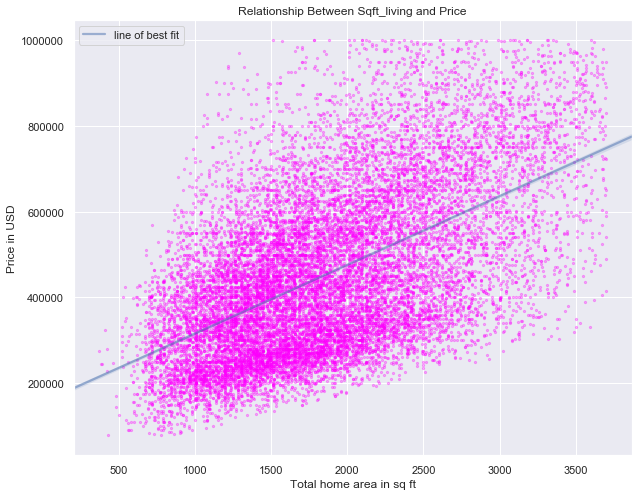

In [311]:
# f_final = 'price~zipcode+sqft_living+lat+grade'  
import seaborn as sns
sns.set()
plt.figure(figsize=(10,8));
sc_kws  ={'color': 'magenta', 'alpha': .3, 's': 5, 'label': 'total area of homes'}
l_kws  ={'alpha': .5, 'label': 'line of best fit'}
sns.regplot(x='sqft_living', y='price', data=df_beforescaler, scatter_kws=sc_kws, line_kws=l_kws);
plt.legend()
plt.title('Relationship Between Sqft_living and Price');
plt.xlabel('Total home area in sq ft');
plt.ylabel('Price in USD')
plt.show;

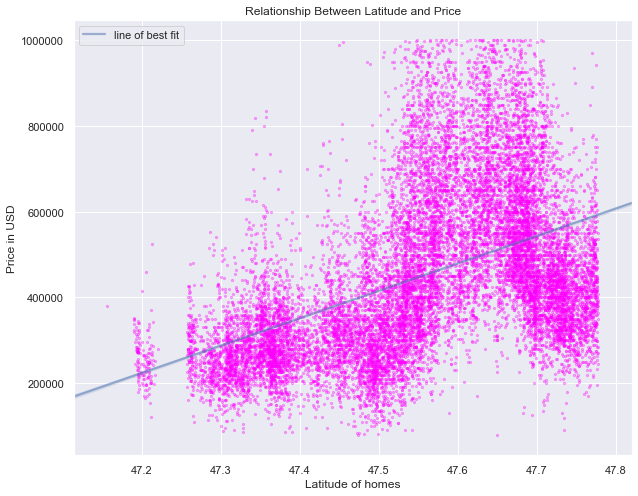

In [312]:
plt.figure(figsize=(10,8));
sc_kws  ={'color': 'magenta', 'alpha': .3, 's': 5, 'label': 'total area of homes'}
l_kws  ={'alpha': .5, 'label': 'line of best fit'}
sns.regplot(x='lat', y='price', data=df_beforescaler, scatter_kws=sc_kws, line_kws=l_kws);

plt.legend()
plt.title('Relationship Between Latitude and Price');
plt.xlabel('Latitude of homes');
plt.ylabel('Price in USD')
plt.show;

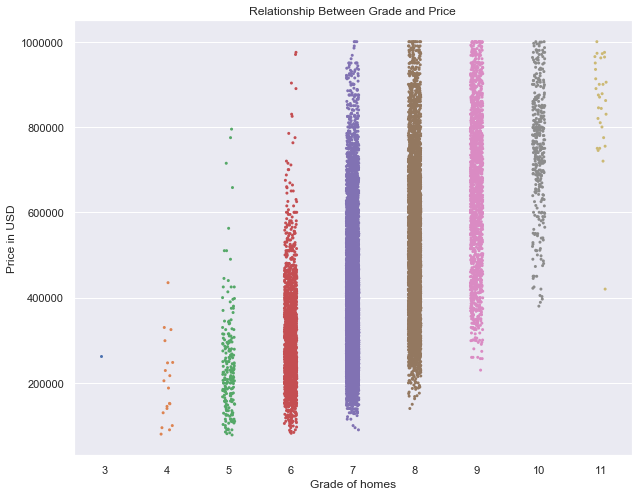

In [313]:
plt.figure(figsize=(10,8));

sns.stripplot(x='grade', y='price', data=df_beforescaler, size=3);

plt.title('Relationship Between Grade and Price');
plt.xlabel('Grade of homes');
plt.ylabel('Price in USD')
plt.show;

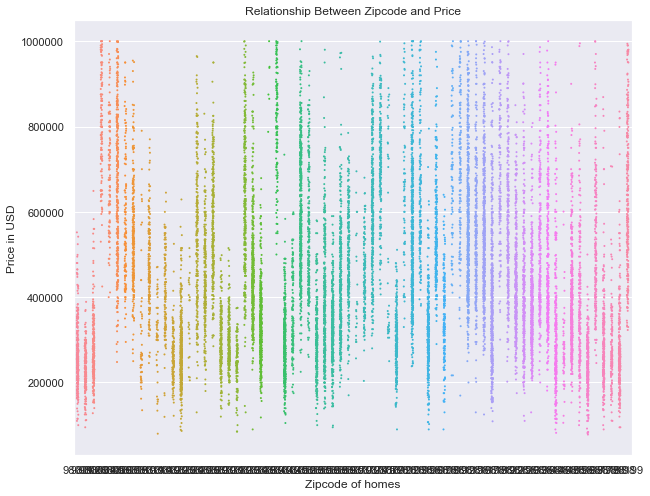

In [314]:
plt.figure(figsize=(10,8));

sns.stripplot(x='zipcode', y='price', data=df_beforescaler, size=2);

plt.title('Relationship Between Zipcode and Price');
plt.xlabel('Zipcode of homes');
plt.ylabel('Price in USD')
plt.show;

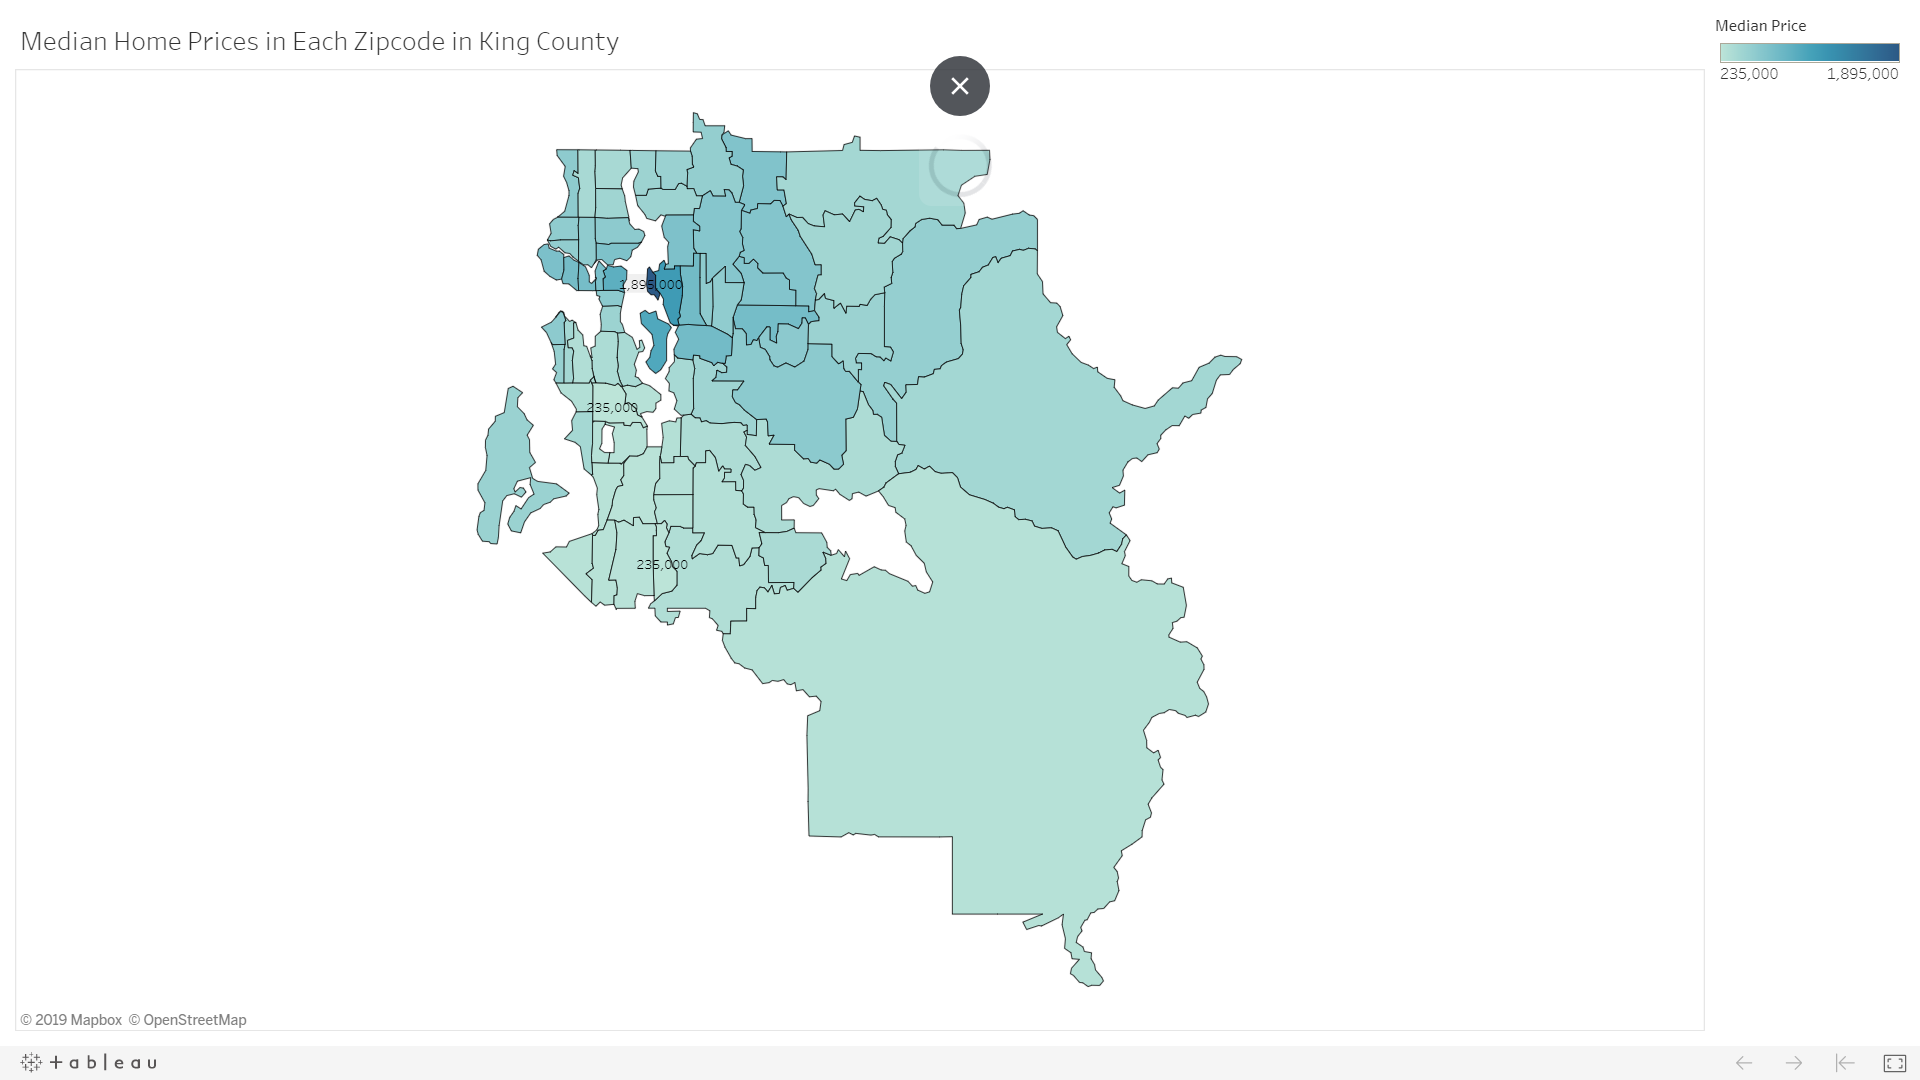